# T036 · An introduction to E(3)-invariant graph neural networks

**Note:** This talktorial is a part of TeachOpenCADD, a platform that aims to teach domain-specific skills and to provide pipeline templates as starting points for research projects.

Authors:

- Joschka Groß, 2022, [Chair for Modelling and Simulation](https://mosi.uni-saarland.de/), [NextAID](https://nextaid.cs.uni-saarland.de/) project, Saarland University

## Aim of this talktorial

This talktorial is supposed to serve as an introduction to machine learning on point cloud representations of molecules with 3D conformer information, i.e., molecular graphs that are embedded into Euclidean space (see **Talktorial 033**). You will learn why Euclidean equivariance and invariance are important properties of neural networks (NNs) that take point clouds as input and learn how to implement and train such NNs. In addition to discussing them in theory, this notebook also aims to demonstrate the shortcomings of plain graph neural networks (GNNs) when working with point clouds practically.

### Contents in *Theory*

* Why 3D coordinates?
* Representing molecules as point clouds
* Equivariance and Invariance in euclidean space and why we care
* How to construct $\text{E}(n)$-invariant and equivariant models
* The QM9 dataset

### Contents in *Practical*

* Visualization of point clouds
* Set up and inspect the QM9 dataset
  * Preprocessing
  * Atomic number distribution and point cloud size
  * Data split, distribution of regression target electronic spatial extent
* Model implementation
  * Plain "naive Euclidean" GNN
  * Demo: Plain GNNs are not E(3)-invariant
  * EGNN model
  * Demo: Our EGNN is E(3)-invariant
* Training and evaluation
  * Setup
  * Training the EGNN
  * Training the plain GNN
  * Comparative evaluation

### References

#### Theoretical
* **Quantum chemistry structures and properties of 134k molecules (QM9)**: [<i>Scientific data</i> (2014)](https://www.nature.com/articles/sdata201422/?ref=https://githubhelp.com)
* **MoleculeNet: a benchmark for molecular machine learning**: [<i>Chem. Sci.</i>, 2018, <b>9</b>, 513-530](https://pubs.rsc.org/en/content/articlehtml/2018/sc/c7sc02664a)
* **E(n)-Equivariant Graph Neural Networks**: [<i>International conference on machine learning</i> (2021), <b>139</b>, 99323-9332](https://proceedings.mlr.press/v139/satorras21a.html)
* **SE(3)-transformers: 3D roto-translation equivariant attention networks**: [<i>Advances in Neural Information Processing Systems</i> (2021), <b>33</b>, 1970-1981](https://proceedings.neurips.cc/paper/2020/file/15231a7ce4ba789d13b722cc5c955834-Paper.pdf)
* **TorchMD-NET: Equivariant Transformers for Neural Network based Molecular Potentials**: [<i>arXiv preprint (2022)</i>](https://arxiv.org/abs/2202.02541)
* **DiffDock**: [<i>arXiv preprint</i> (2022)](https://arxiv.org/abs/2210.01776)

#### Practical
* [Pytorch Geometric QM9 version](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets.QM9)

## Theory

### Why 3D coordinates?

* Some properties are more easily derived when 3D coordinates are known.
* Sometimes the task is to predict properties that are directly linked to Euclidean space, e.g. future atom positions or forces that apply to atoms.
* Compared to molecular graph representations, we in principle only gain information. Covalent bonds can still be inferred from atom types and positions because they can be attributed to overlapping atomic orbitals. Note that one could still include structural information s.t. the model does not have to learn this information itself


An example CADD application that may require the use of 3D coordinates is protein-ligand docking (see **Talktorial 015**). [Recent work from 2022](https://arxiv.org/abs/2210.01776) uses E(3) equivariant graph neural networks as the backbone for a generative model that learns to predict potential ligand docking positions (3D coordinates for the atoms of a given ligand) when additionally given protein structures with 3D information as input.

### Molecules as point clouds: mathematical background
In this talktorial we will focus on atoms and their 3D positions and ignore structural (bond) information. Our mathematical representations of a molecule is thus a point cloud (also see **Talktorial T033**), i.e., a tuple $(X, Z)$ where $Z \in \mathbb{R}^{m \times d}$ is a matrix of $m$ atoms represented by $d$ features each and $X \in \mathbb{R}^{m \times 3}$ captures the atom 3D coordinates. We will assume that the coordinates correspond to a specific molecular conformation (see **Talktorial T033**) of the molecule.

### Equivariance and Invariance in Euclidean space and why we care
When representing molecules as graphs equi- and/or invariance w.r.t. to node permutations are desirable model properties (**Talktorial T033/T035**). When working with point clouds, i.e., when atoms/nodes are embedded into Euclidean space, we should also be concerned about Euclidean symmetry groups. These are groups of transformations $g: \mathbb{R}^n \to \mathbb{R}^n$ that preserve distance, i.e., translations, rotations, reflections, or combinations thereof. For the Euclidean space $\mathbb{R}^n$ with $n$ spatial dimensions, one typically distinguishes between

* the Euclidean group $\text{E}(n)$, which consists of *all* distance-preserving transformations, and
* the special Euclidean group $\text{SE}(n)$, which consists only of translations and rotations.
  
Say $\theta$ is a model that learns atom embeddings $H = \theta(X, Z) \in \mathbb{R}^{m \times q}$ where $q$ is the number of embedding dimensions. We call $\theta$ $\text{E}(n)$-*invariant*, if for all $g \in \text{E}(n)$
$$
\theta(g(X), Z) = \theta(X, Z),
$$
where $g$ is applied row-wise to $X$. Put simply the output of $\theta$ remains unaffected, no matter how we rotate, translate, or reflect the molecule.

If we consider a model that makes predictions about objects which are coupled to the Euclidean space $X' = \theta(X, Z) \in \mathbb{R}^{m \times n}$ (e.g. future atom positions in a dynamical system), we can define $\text{E}(n)$-*equivariance* as
$$
\theta(g(X), Z) = g(\theta(X, Z)),
$$
for all $g \in \text{E}(n)$ applied in row-wise fashion. This is saying that the output of $\theta$ is transformed in the same way as its input. Note that this definition can easily be extended to arbitrary Euclidean features (velocities, electromagnetic forces, ...).

So, why do we care about these properties?

Let's assume our goal was to train a model that predicts the docking position of a ligand when given a fixed protein structure, also with 3D coordinates. Would you trust a model that predicted different relative positions for the ligand atoms when the protein was simply rotated by 180 degrees? If your answer is no, then you should consider using a model that is at least $\text{SE}(3)$-equivariant.
In addition to being a "natural" choice given such considerations, euclidean equivariance empirically also increases the sample complexity (efficiency) of training and improves the model's ability to generalize to unseen data.

**To sum up** it may be helpful to address the problem from a slightly different point of view: Point clouds as representations for molecular conformations are *not unique*. In fact, for one molecular conformation, there are *infinitely many* valid point cloud representations. If $(X, Z)$ is such a representation then $(g(X), Z)$ with $g \in \text{E}(3)$ is too and there are infinitely many such $g$. All $\text{E}(3)$-invariance and equivariance are thus saying, is that our machine learning models *should not care* which of these representations we end up using.


<code>![Figure title](images/2d_rotation_equivariance.png)</code>

*Figure 1:* 
An illustration of a 2D-rotationally equi- and invariant transformation $\phi$.
Taken from [the EGNN paper by Satoras et. al.](https://proceedings.mlr.press/v139/satorras21a.html)

### How to construct $\text{E}(n)$-invariant and equivariant models

Constructing such models is simple if we focus on the fact that all $g \in \text{E}(n)$ are *distance-preserving*. We will not give a [fully-fledged proof](https://proceedings.mlr.press/v139/satorras21a.html), but it should not come as a great surprise that a model which *only considers relative distances between atoms* for computing node (atom) embeddings is guaranteed to be $E(n)$-invariant. We can thus define a *message passing network* $\theta(Z, X)$ with $l=1,\ldots,L$ layers where

$$h_{i}^0 = \psi_0(Z_i)$$
$$d_{ij} = ||X_i - X_j||^2 $$
$$m_{ij}^{l} = \phi_{l}(h_i^l, h_j^l, d_{ij})  \quad \quad \text{for}~l=0,\ldots,L-1$$
$$h_{i}^{l+1} = \psi_l(h_{i}^l, \sum_{j \neq i} m_{ij}^l) \quad \quad \text{for}~l=0,\ldots,L-1$$

and $\psi_0$ computes the initial node embeddings, the $\phi_l$ MLPs $\text{}^1$ construct messages and $\psi_l$ MLPs take care of combining previous embeddings and aggregated messages into new embeddings. The final node embeddings $H = (h_1^L \ldots h_n^L)^t$ computed by this scheme are $E(n)$-invariant.


In the practical part, we will only predict properties that are not directly linked to the Euclidean space, so this kind of network suffices for our purposes. If your goal is to predict e.g. atom positions, you will need to define additional, slightly more sophisticated transformations to ensure that they are $E(3)$-equivariant, but they usually follow the same principle of only using distances in their computations. If you want to read up on this you can take a look at these papers

* [E(n) Equivariant Graph Neural Networks](https://proceedings.mlr.press/v139/satorras21a.html)
* [SE(3) Transformer](https://proceedings.neurips.cc/paper/2020/file/15231a7ce4ba789d13b722cc5c955834-Paper.pdf)
* [TorchMD-Net](https://arxiv.org/abs/2202.02541)

\
\
$~^1$ multi-layer perceptrons (MLPS) are stacks of multiple fully connected layers with non-linear activation functions (also see **Talktorial T022**)

### The QM9 dataset

The QM9 dataset [[1]](https://www.nature.com/articles/sdata201422/?ref=https://githubhelp.com) [[2]](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets.QM9) is part of the [MoleculeNet benchmark](https://pubs.rsc.org/en/content/articlehtml/2018/sc/c7sc02664a) and consists of ~130k small, organic molecules with up to 9 heavy atoms. It also includes targets for various geometric, energetic, electronic and thermodynamic properties. Crucially, it also includes atom 3D coordinates, which makes it suitable for this talktorial.

## Practical

For the practical part, we will be working with a [version of QM9 that is already included in PyTorch Geometric](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets.QM9), as implementing the dataset from scratch would go beyond the scope of this talktorial. We will just inspect the data and briefly discuss how point clouds can be represented by several tensors. Then we will demonstrate how one could use plain GNNs to work with point clouds and why this approach would yield models that are not $\text{E}(3)$ invariant/equivariant. Finally, you will learn how to implement, train and evaluate equivariant GNNs.

In [1]:
import math
import operator
from itertools import chain, product
from functools import partial
from functools import cached_property
from pathlib import Path
from typing import Any, Optional, Callable, Tuple, Dict, Sequence, NamedTuple

import numpy as np

from tqdm import tqdm

import torch
import torch.nn as nn
from torch import Tensor, LongTensor

In [2]:
# import sys
# if sys.platform.startswith(("linux", "darwin")):
#     !mamba install -q -y -c pyg pyg
#     !mamba install -q -y -c conda-forge pytorch_scatter

In [3]:
import torch_geometric
from torch_geometric.transforms import BaseTransform, Compose
from torch_geometric.datasets import QM9
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.data import Dataset
from torch_geometric.nn.aggr import SumAggregation
import torch_geometric.nn as geom_nn

import matplotlib as mpl
import matplotlib.pyplot as plt
from torch_scatter import scatter

In [4]:
# Set path to this notebook
HERE = Path(_dh[-1])
DATA = HERE / "data"

### Visualization of point clouds
The following auxiliary function `plot_point_cloud_3d` will see heavy use later on for the visualization of model input and model outputs.
Note that to visualize molecules rather than their tensor representations used for machine learning, it would be better to use e.g. `RDKit` or `NGLview`.

/var/folders/8r/pydj0px5315ckmngntlp2m3c0000gn/T/ipykernel_36214/3470093051.py:84: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.tight_layout()


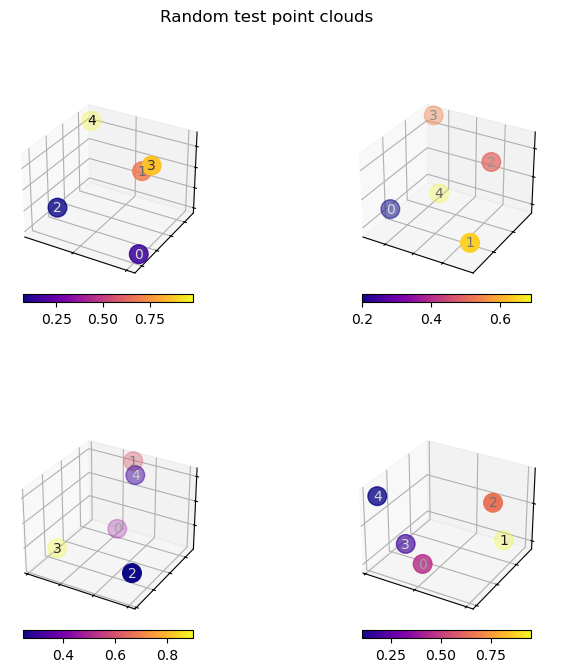

In [32]:
def to_perceived_brightness(rgb: np.ndarray) -> np.ndarray:
    """
    Auxiliary function, useful for choosing label colors
    with good visibility
    """
    r, g, b = rgb
    return 0.1 * r + 0.8 * g + 0.1


def plot_point_cloud_3d(
    fig: mpl.figure.Figure,
    ax_pos: int,
    color: np.ndarray,
    pos: np.ndarray,
    cmap: str = "plasma",
    point_size: float = 180.0,
    label_axes: bool = False,
    annotate_points: bool = True,
    remove_axes_ticks: bool = True,
    cbar_label: str = "",
) -> mpl.axis.Axis:
    """Visualize colored 3D point clouds.

    Parameters
    ----------
    fig : mpl.figure.Figure
        The figure for which a new axis object is added for plotting
    ax_pos : int
        Three-digit integer specifying axis layout and position
        (see docs for `mpl.figure.Figure.add_subplot`)
    color : np.ndarray
        The point colors as a float array of shape `(N,)`
    pos : np.ndarray
        The point xyz-coordinates as an array
    cmap : str, optional
        String identifier for a matplotlib colormap.
        Is used to map the values in `color` to rgb colors.
        , by default "plasma"
    point_size : float, optional
        The size of plotted points, by default 180.0
    label_axes : bool, optional
        whether to label x,y and z axes by default False
    annotate_points : bool, optional
        whether to label points with their index, by default True
    cbar_label : str, optional
        label for the colorbar, by default ""

    Returns
    -------
    mpl.axis.Axis
        The new axis object for the 3D point cloud plot.
    """
    cmap = mpl.colormaps.get_cmap(cmap)
    ax = fig.add_subplot(ax_pos, projection="3d")
    x, y, z = pos
    if remove_axes_ticks:
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_zticklabels([])
    if label_axes:
        ax.set_xlabel("$x$ coordinate")
        ax.set_ylabel("$y$ coordinate")
        ax.set_zlabel("$z$ coordinate")
    sc = ax.scatter(x, y, z, c=color, cmap=cmap, s=point_size)
    plt.colorbar(sc, location="bottom", shrink=0.6, anchor=(0.5, 2), label=cbar_label)
    if annotate_points:
        _colors = sc.cmap(color)
        rgb = _colors[:, :3].transpose()
        brightness = to_perceived_brightness(rgb)
        for i, (xi, yi, zi, li) in enumerate(zip(x, y, z, brightness)):
            ax.text(xi, yi, zi, str(i), None, color=[1 - li] * 3, ha="center", va="center")
    return ax


# testing
fig = plt.figure(figsize=(8, 8))

for ax_pos in [221, 222, 223, 224]:
    pos = np.random.rand(3, 5)
    color = np.random.rand(5)
    plot_point_cloud_3d(fig, ax_pos, color, pos)

fig.suptitle("Random test point clouds")
fig.tight_layout()

In [33]:
def plot_model_input(data: Data, fig: mpl.figure.Figure, ax_pos: int) -> mpl.axis.Axis:
    """
    Plots 3D point cloud model input represented by a torch geometric
    `Data` object. Use atomic numbers as colors.

    Parameters
    ----------
    data : Data
        The 3D point cloud. Must have atomic numbers `z` and 2D coordinates `pos`
        properties that are not `None`.
    fig: mpl.figure.Figure
        The maptlotlib figure to plot on.
    ax_pos:
        Three-digit integer specifying axis layout and position
        (see docs for `mpl.figure.Figure.add_subplot`).

    Returns
    -------
    mpl.axis.Axis
        The newly created axis object.
    """
    color, pos = data.z, data.pos
    color = color.flatten().detach().numpy()
    pos = pos.T.detach().numpy()
    return plot_point_cloud_3d(fig, ax_pos, color, pos, cbar_label="Atomic number")


def plot_model_embedding(
    data: Data, model: Callable[[Data], Tensor], fig: mpl.figure.Figure, ax_pos: int
) -> mpl.axis.Axis:
    """
    Same as `plot_model_input` but instead of node features as color,
    first apply a GNN model to obtain colors from node embeddings.

    Parameters
    ----------
    data : Data
        the model input. Must have 3D coordinates `pos`
        an atomic number `z` properties that are not `None`.
    model : Callable[[Data], Tensor]
        the model must take Data objects as input and return node embeddings
        as a Tensor output.
    fig: mpl.figure.Figure
        The maptlotlib figure to plot on.
    ax_pos:
        Three-digit integer specifying axis layout and position
        (see docs for `mpl.figure.Figure.add_subplot`).

    Returns
    -------
    mpl.axis.Axis
        The newly created axis object.
    """
    x = model(data)
    pos = data.pos
    color = x.flatten().detach().numpy()
    pos = pos.T.detach().numpy()
    return plot_point_cloud_3d(fig, ax_pos, color, pos, cbar_label="Atom embedding (1D)")

### Set up and inspect the QM9 dataset

#### Preprocessing
For the sake of this tutorial, we will restrict ourselves to small molecules with at most 8 heavy atoms. Due to our decision to ignore structural information and treat molecules as point clouds, where every atom interacts with every other atom, we also need to extend the torch geometric `Data` objects with additional adjacency information that represents a complete graph without self-loops.

For performance reasons, both of these steps are performed *once* when pre-processing the raw data using the `pre_filter` and `pre_transform` keyword arguments of the dataset class.

In [7]:
def num_heavy_atoms(qm9_data: Data) -> int:
    """Count the number of heavy atoms in a torch geometric
    Data object.

    Parameters
    ----------
    qm9_data : Data
        A pytorch geometric qm9 data object representing a small molecule
         where atomic numbers are stored in a
        tensor-valued attribute `qm9_data.z`

    Returns
    -------
    int
        The number of heavy atoms in the molecule.
    """
    # every atom with atomic number other than 1 is heavy
    return (qm9_data.z != 1).sum()


def complete_edge_index(n: int) -> LongTensor:
    """
    Constructs a complete edge index.

    NOTE: representing complete graphs
    with sparse edge tensors is arguably a bad idea
    due to performance reasons, but for this tutorial it'll do.

    Parameters
    ----------
    n : int
        the number of nodes in the graph.

    Returns
    -------
    LongTensor
        A PyTorch `edge_index` represents a complete graph with n nodes,
        without self-loops. Shape (2, n).
    """
    # filter removes self loops
    edges = list(filter(lambda e: e[0] != e[1], product(range(n), range(n))))
    return torch.tensor(edges, dtype=torch.long).T


def add_complete_graph_edge_index(data: Data) -> Data:
    """
    On top of any edge information already there,
    add a second edge index that represents
    the complete graph corresponding to a  given
    torch geometric data object

    Parameters
    ----------
    data : Data
        The torch geometric data object.

    Returns
    -------
    Data
        The torch geometric `Data` object with a new
        attribute `complete_edge_index` as described above.
    """
    data.complete_edge_index = complete_edge_index(data.num_nodes)
    return data


#
dataset = QM9(
    DATA,
    # Filter out molecules with more than 8 heavy atoms
    pre_filter=lambda data: num_heavy_atoms(data) < 9,
    # implement point cloud adjacency as a complete graph
    pre_transform=add_complete_graph_edge_index,
)

print(f"Num. examples in QM9 restricted to molecules with at most 8 heavy atoms: {len(dataset)}")

Extracting /Users/joschka/teachopencadd/teachopencadd/talktorials/T036_e3_equivariant_gnn/data/raw/qm9.zip
Processing...
100%|██████████| 133885/133885 [01:47<00:00, 1247.03it/s]


Num. examples in QM9 restricted to molecules with at most 8 heavy atoms: 21800


Done!


NOTE: executing the above cell for the first time first downloads and then processes the raw data, which **might take a while**.

Indexing the dataset we just created returns a single Pytorch Geometric `Data` object representing one molecular graph/point cloud. You can think of these objects as dictionaries with some extra utility methods already implemented.

In [8]:
data = dataset[0]
# This displays all named data attributes, and their shapes (in the case of tensors), or values (in the case of other data).
data

Data(x=[5, 11], edge_index=[2, 8], edge_attr=[8, 4], y=[1, 19], pos=[5, 3], z=[5], smiles='[H]C([H])([H])[H]', name='gdb_1', idx=[1], complete_edge_index=[2, 20])

For index 0 (name `gdb_1`) this should be the molecule CH4. We can check this by looking into the atomic numbers stored in the attributed named `z`

In [9]:
data.z

tensor([6, 1, 1, 1, 1])

For molecules with `N` atoms and `M` (covalent) bonds, the data objects also contain named tensors of shape

* `Data.x`: `(N, d_node)` node-level features (e.g. formal charge, membership to aromatic rings, chirality, ...), but we will ignore them here and just use atomic numbers.
* `Data.y`: `(19,)` regression targets
* `Data.edge_index`: `(2, M)` edges between atoms derived from covalent bonds, stored as source and target node index pairs.
* `Data.edge_attr`: `(M, d_edge)` contains bond features (e.g. bond type, ring-membership, ...)
* `Data.pos`: `(N, 3)` most interesting to us, atom 3D coordinates.
* `Data.complete_edge_index`: `(2, (N-1)^2)`: the complete graph edge index (without self-loops) we added earlier.

The input to our (point cloud) model we will implement later can be visualized using just `Data.z` as color and `Data.pos` as scatter plot positions. Note: the alpha channel of colors is used to convey depth-information.

In [10]:
data.pos.round(decimals=2)

tensor([[-0.0100,  1.0900,  0.0100],
        [ 0.0000, -0.0100,  0.0000],
        [ 1.0100,  1.4600,  0.0000],
        [-0.5400,  1.4500, -0.8800],
        [-0.5200,  1.4400,  0.9100]])

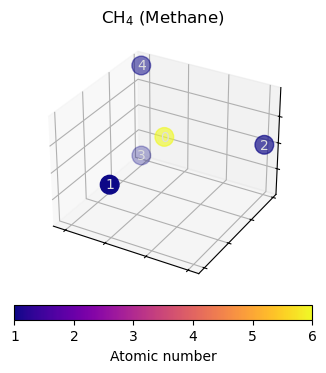

In [34]:
fig = plt.figure()
ax = plot_model_input(data, fig, 111)
_ = ax.set_title("CH$_4$ (Methane)")

#### Atomic number distribution and point cloud size
Now that our dataset is set up, and we have a basic understanding of how molecules are represented, we can try to visualize the properties of the entire dataset.
Let us first look at the distribution of node-level features (atomic numbers) and the point cloud size (number of atoms) aggregated over the entire dataset.

/Users/joschka/mambaforge/envs/teachopencadd-t033/lib/python3.11/site-packages/torch_geometric/data/in_memory_dataset.py:284: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. The data of the dataset is already cached, so any modifications to `data` will not be reflected when accessing its elements. Clearing the cache now by removing all elements in `dataset._data_list`. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


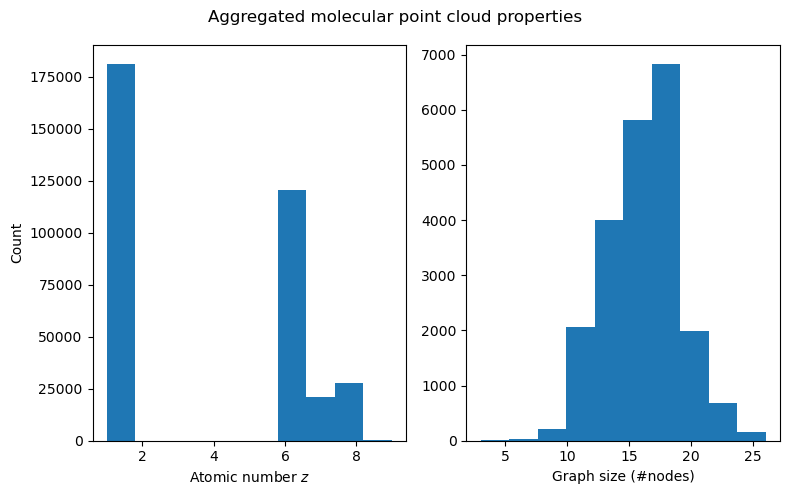

In [35]:
fig, (ax_atoms, ax_graph_size) = plt.subplots(1, 2, figsize=(8, 5))

# ax_atoms.hist(dataset.data.z[dataset.data.z != 1])
ax_atoms.hist(dataset.data.z)
ax_atoms.set_xlabel("Atomic number $z$")
ax_atoms.set_ylabel("Count")
num_nodes = [dataset[i].num_nodes for i in range(len(dataset))]
ax_graph_size.hist(num_nodes)
ax_graph_size.set_xlabel("Graph size (#nodes)")
fig.suptitle("Aggregated molecular point cloud properties")
fig.tight_layout()

We can see that while fluorine atoms (number 9) show up in the data, they are heavily underrepresented (the bar at $z=9$ is barely visible), which is not a nice property that is likely since we shrunk the dataset. The number of atoms seems to be roughly normally distributed, which is nice.

#### Data split, distribution of regression target electronic spatial extent
Next, we will implement data splitting, choose a regression target and visualize the split w.r.t. to this target. 
Out of the 19 regression targets included in QM9, we'll focus on *electronic spatial extent*, which, simply put, describes the volume of a molecule, so it should be a good fit for methods that use 3D information.
Let us now start with implementing a *data module* that takes care of train/val/test splits and of indexing the correct target.

In [36]:
class SelectTarget(BaseTransform):
    def __init__(self, target_index: int) -> None:
        super().__init__()
        self.target_index = target_index

    def forward(self, data):
        data.y = data.y[:, self.target_index]
        return data


class TargetNormalization(BaseTransform):
    def __init__(self, mean: torch.Tensor, std: torch.Tensor) -> None:
        super().__init__()
        self.mean = mean
        self.std = std

    def forward(self, data):
        data.y = (data.y - self.mean) / self.std
        return data

    @classmethod
    def fit(cls, dataset, dim: int = 0, cat_dim: int = 0) -> "TargetNormalization":
        y = torch.cat([dataset.get(i).y for i in range(len(dataset))], dim=cat_dim)
        mean = y.mean(dim=dim, keepdim=True)
        std = y.std(dim=dim, keepdim=True)
        return cls(mean, std)

In [37]:
class QM9DataModule:
    def __init__(
        self,
        train_ratio: float = 0.8,
        val_ratio: float = 0.1,
        test_ratio: float = 0.1,
        target_idx: int = 5,
        seed: float = 420,
    ) -> None:
        """Encapsulates everything related to the dataset

        Parameters
        ----------
        train_ratio : float, optional
            fraction of data used for training, by default 0.8
        val_ratio : float, optional
            fraction of data used for validation, by default 0.1
        test_ratio : float, optional
            fraction of data used for testing, by default 0.1
        target_idx : int, optional
            index of the target (see torch geometric docs), by default 5 (electronic spatial extent)
            (https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html?highlight=qm9#torch_geometric.datasets.QM9)
        seed : float, optional
            random seed for data split, by default 420
        """
        assert sum([train_ratio, val_ratio, test_ratio]) == 1
        self.target_idx = target_idx
        self.num_examples = len(self._dataset())
        rng = np.random.default_rng(seed)
        self.shuffled_index = rng.permutation(self.num_examples)
        self.train_split = self.shuffled_index[: int(self.num_examples * train_ratio)]
        self.val_split = self.shuffled_index[
            int(self.num_examples * train_ratio) : int(
                self.num_examples * (train_ratio + val_ratio)
            )
        ]
        self.test_split = self.shuffled_index[
            int(self.num_examples * (train_ratio + val_ratio)) : self.num_examples
        ]

    def _dataset(self):
        return QM9(
            DATA,
            pre_filter=lambda data: num_heavy_atoms(data) < 9,
            pre_transform=add_complete_graph_edge_index,
        )

    @cached_property
    def dataset(self, transform=None) -> QM9:
        dataset = self._dataset()
        normalize_target = TargetNormalization.fit(dataset[self.train_split])
        select_target = SelectTarget(self.target_idx)
        return QM9(
            DATA,
            pre_filter=lambda data: num_heavy_atoms(data) < 9,
            pre_transform=add_complete_graph_edge_index,
            transform=Compose([normalize_target, select_target]),
        )

    @cached_property
    def target(self):
        return torch.cat(
            [self.dataset.get(i).y[:, self.target_idx] for i in range(len(self.dataset))], dim=0
        )

    def loader(self, split, **loader_kwargs) -> DataLoader:
        dataset = self.dataset[split]
        return DataLoader(dataset, **loader_kwargs)

    def train_loader(self, **loader_kwargs) -> DataLoader:
        return self.loader(self.train_split, shuffle=True, **loader_kwargs)

    def val_loader(self, **loader_kwargs) -> DataLoader:
        return self.loader(self.val_split, shuffle=False, **loader_kwargs)

    def test_loader(self, **loader_kwargs) -> DataLoader:
        return self.loader(self.test_split, shuffle=False, **loader_kwargs)

Now we can easily plot the target across the data split.

Text(0.5, 0.98, 'Random data split - target distribution')

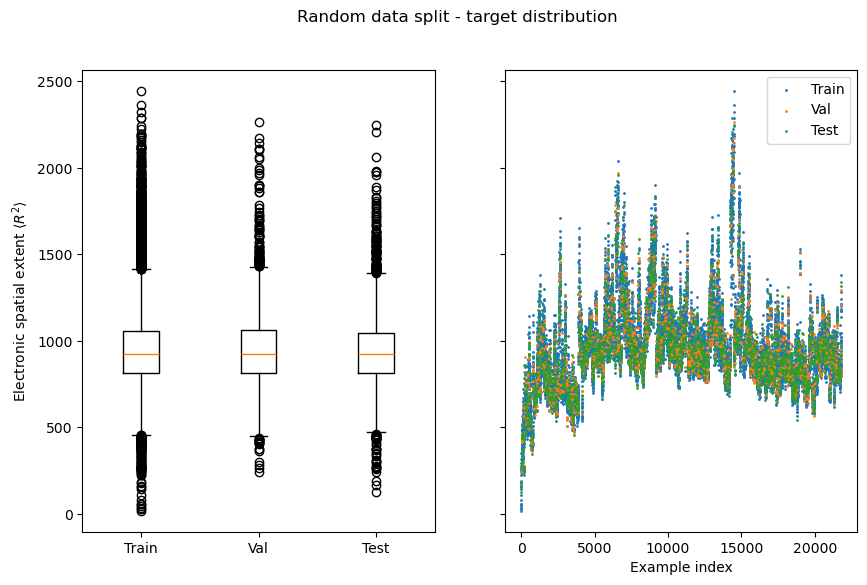

In [38]:
data_module = QM9DataModule()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6), sharey=True)
target = data_module.target.flatten().numpy()
ax1.boxplot(
    [
        target[data_module.train_split],
        target[data_module.val_split],
        target[data_module.test_split],
    ]
)
ax1.set_xticklabels(["Train", "Val", "Test"])
ax1.set_ylabel("Electronic spatial extent $\langle R^2 \\rangle$")

for label, split in {
    "Train": data_module.train_split,
    "Val": data_module.val_split,
    "Test": data_module.test_split,
}.items():
    ax2.scatter(split, target[split], label=label, s=1)

ax2.set_xlabel("Example index")
ax2.legend()
fig.suptitle("Random data split - target distribution")

You should be able to observe that random splits are typically very homogenous, which means measuring generalization capabilities with them can yield deceivingly good results.

### Model implementation

#### Plain "naive Euclidean" GNN
A naive way to incorporate 3D coordinates into a GNN for molecular graphs would be to interpret them as atom-level features that are simply combined with the other features.
It is easy to implement a simple baseline model which does exactly this (see **Talktorial T035**).
For its message-passing topology, our implementation uses the edges induced by bonds between atoms.

In [41]:
class NaiveEuclideanGNN(nn.Module):
    def __init__(
        self,
        hidden_channels: int,
        num_layers: int,
        num_spatial_dims: int,
        final_embedding_size: Optional[int] = None,
        act: nn.Module = nn.ReLU(),
    ) -> None:
        super().__init__()
        # NOTE nn.Embedding acts like a lookup table.
        # Here we use it to store each atomic number in [0,100]
        # a learnable, fixed-size vector representation
        self.f_initial_embed = nn.Embedding(100, hidden_channels)
        self.f_pos_embed = nn.Linear(num_spatial_dims, hidden_channels)
        self.f_combine = nn.Sequential(nn.Linear(2 * hidden_channels, hidden_channels), act)

        if final_embedding_size is None:
            final_embedding_size = hidden_channels

        # Graph isomorphism network as main GNN
        # (see Talktorial 034)
        # takes care of message passing and
        # Learning node-level embeddings
        self.gnn = geom_nn.models.GIN(
            in_channels=hidden_channels,
            hidden_channels=hidden_channels,
            out_channels=final_embedding_size,
            num_layers=num_layers,
            act=act,
        )

        # modules required for aggregating node embeddings
        # into graph embeddings and making graph-level predictions
        self.aggregation = geom_nn.aggr.SumAggregation()
        self.f_predict = nn.Sequential(
            nn.Linear(final_embedding_size, final_embedding_size),
            act,
            nn.Linear(final_embedding_size, 1),
        )

    def encode(self, data: Data) -> Tensor:
        # initial atomic number embedding and embedding od positional information
        atom_embedding = self.f_initial_embed(data.z)
        pos_embedding = self.f_pos_embed(data.pos)

        # treat both as plain node-level features and combine into initial node-level
        # embedddings
        initial_node_embed = self.f_combine(torch.cat((atom_embedding, pos_embedding), dim=-1))

        # message passing
        # NOTE in contrast to the EGNN implemented later, this model does use bond information
        # i.e., data.egde_index stems from the bond adjacency matrix
        node_embed = self.gnn(initial_node_embed, data.edge_index)
        return node_embed

    def forward(self, data: Data) -> Tensor:
        node_embed = self.encode(data)
        aggr = self.aggregation(node_embed, data.batch)
        return self.f_predict(aggr)

#### Demo: Plain GNNs are not $\text{E(3)}$-invariant
However, this approach is problematic because the corresponding atom embeddings of a regular GNN (from which we would also derive our final predictions) will not be $\text{E}(3)$-invariant. This can be demonstrated easily:

In [42]:
# use rotations along z-axis as demo e(3) transformation
def rotation_matrix_z(theta: float) -> Tensor:
    """Generates a rotation matrix and returns
    a corresponing tensor. The rotation is about the $z$-axis.
    (https://en.wikipedia.org/wiki/Rotation_matrix)

    Parameters
    ----------
    theta : float
        the angle of rotation.

    Returns
    -------
    Tensor
        the rotation matrix as float tensor.
    """
    return torch.tensor(
        [
            [math.cos(theta), -math.sin(theta), 0],
            [math.sin(theta), math.cos(theta), 0],
            [0, 0, 1],
        ]
    )

*NOTE*: you may need to run the cell below multiple times to find a model initialization for which non-invariance can easily be observed.

/var/folders/8r/pydj0px5315ckmngntlp2m3c0000gn/T/ipykernel_36214/2912899843.py:32: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


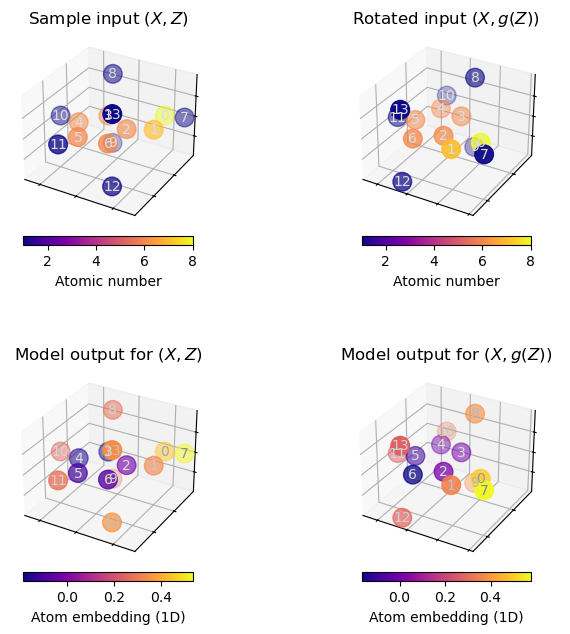

In [43]:
# Some data points from qm9
sample_data = dataset[800].clone()

# apply an E(3) transformation
rotated_sample_data = sample_data.clone()
rotated_sample_data.pos = rotated_sample_data.pos @ rotation_matrix_z(45)

# initialize a model with 2 hidden layers, 32 hidden channels,
# that outputs 1-dimensional node embeddings
model = NaiveEuclideanGNN(
    hidden_channels=32,
    num_layers=2,
    num_spatial_dims=3,
    final_embedding_size=1,
)

# make a plot that demonstrates non-equivariance
# fig, axes = plt.subplots(2, 2, figsize=(8,8), sharex=True, sharey=True)
fig = plt.figure(figsize=(8, 8))

ax1 = plot_model_input(sample_data, fig, 221)
ax1.set_title("Sample input $(X, Z)$")

ax2 = plot_model_input(rotated_sample_data, fig, 222)
ax2.set_title("Rotated input $(X, g(Z))$")

ax3 = plot_model_embedding(sample_data, model.encode, fig, 223)
ax3.set_title("Model output for $(X, Z)$")

ax4 = plot_model_embedding(rotated_sample_data, model.encode, fig, 224)
ax4.set_title("Model output for $(X, g(Z))$")
fig.tight_layout()

When executing the above cells a few times, we can observe that rotating the molecule may *significantly* alter the atom embeddings obtained from the plain GNN model.

#### EGNN model

We now implement an $\text{E}(n)$-invariant GNN based on the principles outlined in the theory section.

In [44]:
class EquivariantMPLayer(nn.Module):
    def __init__(
        self,
        in_channels: int,
        hidden_channels: int,
        act: nn.Module,
    ) -> None:
        super().__init__()
        self.act = act
        self.residual_proj = nn.Linear(in_channels, hidden_channels, bias=False)

        # Messages will consist of two (source and target) node embeddings and a scalar distance
        message_input_size = 2 * in_channels + 1

        # equation (3) "phi_l" NN
        self.message_mlp = nn.Sequential(
            nn.Linear(message_input_size, hidden_channels),
            act,
        )
        # equation (4) "psi_l" NN
        self.node_update_mlp = nn.Sequential(
            nn.Linear(in_channels + hidden_channels, hidden_channels),
            act,
        )

    def node_message_function(
        self,
        source_node_embed: Tensor,  # h_i
        target_node_embed: Tensor,  # h_j
        node_dist: Tensor,  # d_ij
    ) -> Tensor:
        # implements equation (3)
        message_repr = torch.cat((source_node_embed, target_node_embed, node_dist), dim=-1)
        return self.message_mlp(message_repr)

    def compute_distances(self, node_pos: Tensor, edge_index: LongTensor) -> Tensor:
        row, col = edge_index
        xi, xj = node_pos[row], node_pos[col]
        # relative squared distance
        # implements equation (2) ||X_i - X_j||^2
        rsdist = (xi - xj).pow(2).sum(1, keepdim=True)
        return rsdist

    def forward(
        self,
        node_embed: Tensor,
        node_pos: Tensor,
        edge_index: Tensor,
    ) -> Tensor:
        row, col = edge_index
        dist = self.compute_distances(node_pos, edge_index)

        # compute messages "m_ij" from  equation (3)
        node_messages = self.node_message_function(node_embed[row], node_embed[col], dist)

        # message sum aggregation in equation (4)
        aggr_node_messages = scatter(node_messages, col, dim=0, reduce="sum")

        # compute new node embeddings "h_i^{l+1}"
        # (implements rest of equation (4))
        new_node_embed = self.residual_proj(node_embed) + self.node_update_mlp(
            torch.cat((node_embed, aggr_node_messages), dim=-1)
        )

        return new_node_embed


class EquivariantGNN(nn.Module):
    def __init__(
        self,
        hidden_channels: int,
        final_embedding_size: Optional[int] = None,
        target_size: int = 1,
        num_mp_layers: int = 2,
    ) -> None:
        super().__init__()
        if final_embedding_size is None:
            final_embedding_size = hidden_channels

        # non-linear activation func.
        # usually configurable, here we just use Relu for simplicity
        self.act = nn.ReLU()

        # equation (1) "psi_0"
        self.f_initial_embed = nn.Embedding(100, hidden_channels)

        # create stack of message passing layers
        self.message_passing_layers = nn.ModuleList()
        channels = [hidden_channels] * (num_mp_layers) + [final_embedding_size]
        for d_in, d_out in zip(channels[:-1], channels[1:]):
            layer = EquivariantMPLayer(d_in, d_out, self.act)
            self.message_passing_layers.append(layer)

        # modules required for readout of a graph-level
        # representation and graph-level property prediction
        self.aggregation = SumAggregation()
        self.f_predict = nn.Sequential(
            nn.Linear(final_embedding_size, final_embedding_size),
            self.act,
            nn.Linear(final_embedding_size, target_size),
        )

    def encode(self, data: Data) -> Tensor:
        # theory, equation (1)
        node_embed = self.f_initial_embed(data.z)
        # message passing
        # theory, equation (3-4)
        for mp_layer in self.message_passing_layers:
            # NOTE here we use the complete edge index defined by the transform earlier on
            # to implement the sum over $j \neq i$ in equation (4)
            node_embed = mp_layer(node_embed, data.pos, data.complete_edge_index)
        return node_embed

    def _predict(self, node_embed, batch_index) -> Tensor:
        aggr = self.aggregation(node_embed, batch_index)
        return self.f_predict(aggr)

    def forward(self, data: Data) -> Tensor:
        node_embed = self.encode(data)
        pred = self._predict(node_embed, data.batch)
        return pred

#### Demo: Our EGNN is $E(3)$-invariant
We can collect evidence that this model is indeed $\text{E}(n)$-invariant by repeating the experiment we conducted earlier.

In [45]:
model = EquivariantGNN(hidden_channels=32, final_embedding_size=1, num_mp_layers=2)

/var/folders/8r/pydj0px5315ckmngntlp2m3c0000gn/T/ipykernel_36214/1099465595.py:21: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.tight_layout()


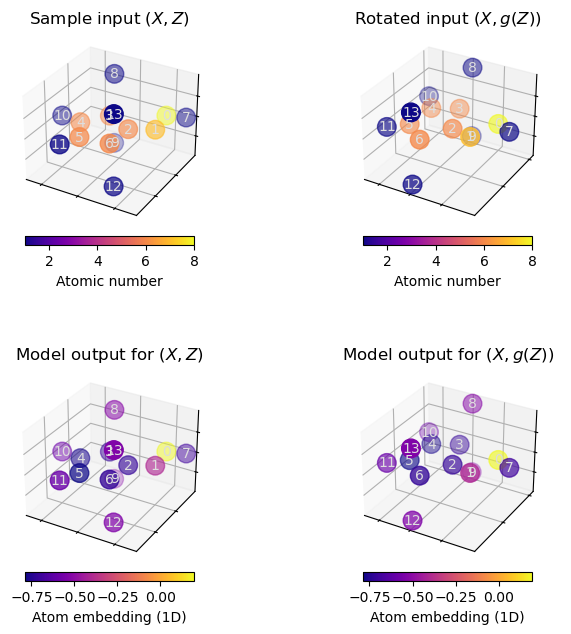

In [46]:
# Some data points from qm9
sample_data = dataset[800].clone()

# apply E(3) transformation
rotated_sample_data = sample_data.clone()
rotated_sample_data.pos = rotated_sample_data.pos @ rotation_matrix_z(120)

fig = plt.figure(figsize=(8, 8))

ax1 = plot_model_input(sample_data, fig, 221)
ax1.set_title("Sample input $(X, Z)$")

ax2 = plot_model_input(rotated_sample_data, fig, 222)
ax2.set_title("Rotated input $(X, g(Z))$")

ax3 = plot_model_embedding(sample_data, model.encode, fig, 223)
ax3.set_title("Model output for $(X, Z)$")

ax4 = plot_model_embedding(rotated_sample_data, model.encode, fig, 224)
ax4.set_title("Model output for $(X, g(Z))$")
fig.tight_layout()

You can execute the above cells as often as you like, with whatever input you choose, the atom embeddings will always be unaffected by the rotation applied to the model input.

### Training and evaluation
Now that we have set up our data and implemented two different models for point clouds, we can start implementing a training and evaluation pipeline.

We will follow the ubiquitous ML principle of also monitoring a validation loss in addition to the training loss. The validation loss acts as an estimate for how well the model generalizes and can be used for selecting a final model to be tested.

In [51]:
# We will be using mean absolute error
# as a metric for validation and testing
def total_absolute_error(pred: Tensor, target: Tensor, batch_dim: int = 0) -> Tensor:
    """Total absolute error, i.e. sums over batch dimension.

    Parameters
    ----------
    pred : Tensor
        batch of model predictions
    target : Tensor
        batch of ground truth / target values
    batch_dim : int, optional
        dimension that indexes batch elements, by default 0

    Returns
    -------
    Tensor
        total absolute error
    """
    target = target.view(pred.size())
    return (pred - target).abs().sum(batch_dim)

In [55]:
def run_epoch(
    model: nn.Module,
    loader: DataLoader,
    criterion: Callable[[Tensor, Tensor], Tensor],
    pbar: Optional[Any] = None,
    optim: Optional[torch.optim.Optimizer] = None,
):
    """Run a single epoch.

    Parameters
    ----------
    model : nn.Module
        the NN used for regression
    loader : DataLoader
        an iterable over data batches
    criterion : Callable[[Tensor, Tensor], Tensor]
        a criterion (loss) that is optimized
    pbar : Optional[Any], optional
        a tqdm progress bar, by default None
    optim : Optional[torch.optim.Optimizer], optional
        a optimizer that is optimizing the criterion, by default None
    """

    def step(
        data_batch: Data,
    ) -> Tuple[float, float]:
        """Perform a single train/val step on a data batch.

        Parameters
        ----------
        data_batch : Data

        Returns
        -------
        Tuple[float, float]
            Loss (mean squared error) and validation critierion (absolute error).
        """
        pred = model.forward(data_batch)
        target = data_batch.y
        target = target.view(pred.size())
        loss = criterion(pred, target)
        if optim is not None:
            optim.zero_grad()
            loss.backward()
            optim.step()
        return loss.detach().item(), total_absolute_error(pred.detach(), target.detach())

    if optim is not None:
        model.train()
        # This enables pytorch autodiff s.t. we can compute gradients
        model.requires_grad_(True)
    else:
        model.eval()
        # disable autodiff: when evaluating we do not need to track gradients
        model.requires_grad_(False)

    total_loss = 0
    total_mae = 0
    for data in loader:
        loss, mae = step(data)
        total_loss += loss * data.num_graphs
        total_mae += mae
        if pbar is not None:
            pbar.update(1)

    return total_loss / len(loader.dataset), total_mae / len(loader.dataset)


def train_model(
    data_module: QM9DataModule,
    model: nn.Module,
    num_epochs: int = 30,
    lr: float = 3e-4,
    batch_size: int = 32,
    weight_decay: float = 1e-8,
    best_model_path: Path = DATA.joinpath("trained_model.pth"),
) -> Dict[str, Any]:
    """Takes data and model as input and runs training, collecting additional validation metrics
    while doing so.

    Parameters
    ----------
    data_module : QM9DataModule
        a data module as defined earlier
    model : nn.Module
        a gnn model
    num_epochs : int, optional
        number of epochs to train for, by default 30
    lr : float, optional
        "learning rate": optimizer SGD step size, by default 3e-4
    batch_size : int, optional
        number of examples used for one training step, by default 32
    weight_decay : float, optional
        L2 regularization parameter, by default 1e-8
    best_model_path : Path, optional
        path where the model weights with lowest val. error should be stored
        , by default DATA.joinpath("trained_model.pth")

    Returns
    -------
    Dict[str, Any]
        a training result, ie statistics and info about the model
    """
    # create data loaders
    train_loader = data_module.train_loader(batch_size=batch_size)
    val_loader = data_module.val_loader(batch_size=batch_size)

    # setup optimizer and loss
    optim = torch.optim.Adam(model.parameters(), lr, weight_decay=1e-8)
    loss_fn = nn.MSELoss()

    # keep track of the epoch with the best validation mae
    # st we can save the "best" model weights
    best_val_mae = float("inf")

    # Statistics that will be plotted later on
    # and model info
    result = {
        "model": model,
        "path_to_best_model": best_model_path,
        "train_loss": np.full(num_epochs, float("nan")),
        "val_loss": np.full(num_epochs, float("nan")),
        "train_mae": np.full(num_epochs, float("nan")),
        "val_mae": np.full(num_epochs, float("nan")),
    }

    # Auxiliary functions for updating and reporting
    # Training progress statistics
    def update_statistics(i_epoch: int, **kwargs: float):
        for key, value in kwargs.items():
            result[key][i_epoch] = value

    def desc(i_epoch: int) -> str:
        return " | ".join(
            [f"Epoch {i_epoch + 1:3d} / {num_epochs}"]
            + [
                f"{key}: {value[i_epoch]:8.2f}"
                for key, value in result.items()
                if isinstance(value, np.ndarray)
            ]
        )

    # main training loop
    for i_epoch in range(0, num_epochs):
        progress_bar = tqdm(total=len(train_loader) + len(val_loader))
        try:
            # tqdm for reporting progress
            progress_bar.set_description(desc(i_epoch))

            # training epoch
            train_loss, train_mae = run_epoch(model, train_loader, loss_fn, progress_bar, optim)
            # validation epoch
            val_loss, val_mae = run_epoch(model, val_loader, loss_fn, progress_bar)

            update_statistics(
                i_epoch,
                train_loss=train_loss,
                val_loss=val_loss,
                train_mae=train_mae,
                val_mae=val_mae,
            )

            progress_bar.set_description(desc(i_epoch))

            if val_mae < best_val_mae:
                best_val_mae = val_mae
                torch.save(model.state_dict(), best_model_path)
        finally:
            progress_bar.close()

    return result

In [56]:
@torch.no_grad()
def test_model(model: nn.Module, data_module: QM9DataModule) -> Tuple[float, Tensor, Tensor]:
    """
    Test a model.

    Parameters
    ----------
    model : nn.Module
        a trained model
    data_module : QM9DataModule
        a data module as defined earlier
        from which we'll get the test data

    Returns
    -------
    _Tuple[float, Tensor, Tensor]
        Test MAE, and model predictions & targets for further processing
    """
    test_mae = 0
    preds, targets = [], []
    loader = data_module.test_loader()
    for data in loader:
        pred = model(data)
        target = data.y
        preds.append(pred)
        targets.append(target)
        test_mae += total_absolute_error(pred, target).item()

    test_mae = test_mae / len(data_module.test_split)

    return test_mae, torch.cat(preds, dim=0), torch.cat(targets, dim=0)

#### Training the EGNN

In [64]:
model = EquivariantGNN(hidden_channels=64, num_mp_layers=2)

egnn_train_result = train_model(
    data_module,
    model,
    num_epochs=10,
    lr=1e-3,
    batch_size=32,
    weight_decay=1e-6,
    best_model_path=DATA.joinpath("trained_egnn.pth"),
)

Epoch   1 / 10 | train_loss:     1.52 | val_loss:     0.03 | train_mae:     0.38 | val_mae:     0.16: 100%|██████████| 614/614 [00:16<00:00, 37.23it/s]
Epoch   2 / 10 | train_loss:     0.02 | val_loss:     0.02 | train_mae:     0.10 | val_mae:     0.13: 100%|██████████| 614/614 [00:16<00:00, 36.55it/s]
Epoch   3 / 10 | train_loss:     0.03 | val_loss:     0.02 | train_mae:     0.12 | val_mae:     0.12: 100%|██████████| 614/614 [00:17<00:00, 34.12it/s]
Epoch   4 / 10 | train_loss:     0.01 | val_loss:     0.01 | train_mae:     0.08 | val_mae:     0.09: 100%|██████████| 614/614 [00:22<00:00, 27.37it/s]
Epoch   5 / 10 | train_loss:     0.02 | val_loss:     0.01 | train_mae:     0.09 | val_mae:     0.07: 100%|██████████| 614/614 [00:19<00:00, 31.94it/s]
Epoch   6 / 10 | train_loss:     0.01 | val_loss:     0.00 | train_mae:     0.07 | val_mae:     0.05: 100%|██████████| 614/614 [00:21<00:00, 28.65it/s]
Epoch   7 / 10 | train_loss:     0.01 | val_loss:     0.01 | train_mae:     0.08 | val_m

#### Training the plain GNN

In [65]:
gcn_baseline = NaiveEuclideanGNN(64, 4, 3)

gcn_train_result = train_model(
    data_module,
    gcn_baseline,
    num_epochs=30,
    lr=1e-3,
    batch_size=32,
    weight_decay=1e-6,
    best_model_path=DATA.joinpath("trained_gnn.pth"),
)

Epoch   1 / 30 | train_loss:     0.38 | val_loss:     0.38 | train_mae:     0.43 | val_mae:     0.43: 100%|██████████| 614/614 [00:09<00:00, 66.95it/s] 
Epoch   2 / 30 | train_loss:     0.24 | val_loss:     0.26 | train_mae:     0.35 | val_mae:     0.36: 100%|██████████| 614/614 [00:08<00:00, 69.98it/s] 
Epoch   3 / 30 | train_loss:     0.18 | val_loss:     0.16 | train_mae:     0.31 | val_mae:     0.30: 100%|██████████| 614/614 [00:08<00:00, 74.01it/s] 
Epoch   4 / 30 | train_loss:     0.14 | val_loss:     0.15 | train_mae:     0.27 | val_mae:     0.26: 100%|██████████| 614/614 [00:08<00:00, 73.55it/s] 
Epoch   5 / 30 | train_loss:     0.11 | val_loss:     0.09 | train_mae:     0.24 | val_mae:     0.22: 100%|██████████| 614/614 [00:08<00:00, 73.44it/s] 
Epoch   6 / 30 | train_loss:     0.09 | val_loss:     0.09 | train_mae:     0.22 | val_mae:     0.21: 100%|██████████| 614/614 [00:08<00:00, 73.58it/s] 
Epoch   7 / 30 | train_loss:     0.07 | val_loss:     0.07 | train_mae:     0.20 |

#### Comparative evaluation

Let us now compare the trained EGNN and GNN baseline model. First note that in terms of capacity (measured by the number of trainable parameters) the models are very similar. But be aware that the comparison is still not completely fair, because

* the EGNN is a *message-passing* neural network while the baseline GNN is a type of *graph convolutional* neural network
* the EGNN is run on complete graphs, whereas the baseline GNN uses the bond adjacency info, which could also be a disadvantage

In [66]:
gcn_num_params = sum(p.numel() for p in gcn_train_result["model"].parameters())
egnn_num_params = sum(p.numel() for p in egnn_train_result["model"].parameters())

for key, value in {"GCN": gcn_num_params, "EGNN": egnn_num_params}.items():
    print(f"{key} has {value} parameters")

GCN has 52417 parameters
EGNN has 51969 parameters


Plotting the loss and validation MAE for each epoch, we can observe that the EGNN training progresses *much* faster and yields *much* better results,
even though it is trained for a smaller number of epochs (note that loss and MAE are in log-scale).

Surprisingly the validation loss/MAE for the EGNN is sometimes *lower* than the train loss/MAE. This might be explained by the fact that the data split is *very* homogenous, and the validation data contains fewer outliers than the train data (see box plots from the section on distribution of regression target across splits).

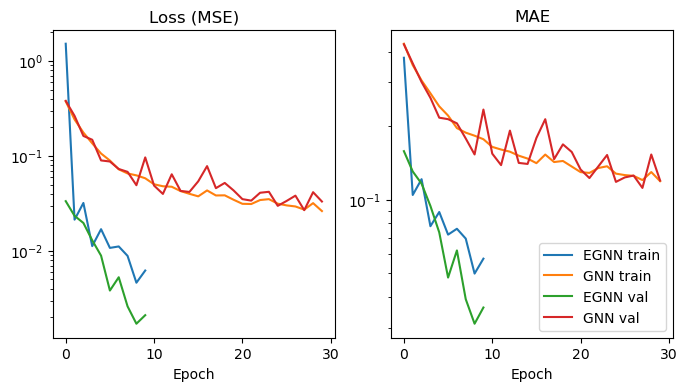

In [67]:
fig, (loss_ax, mae_ax) = plt.subplots(1, 2, figsize=(8, 4))

loss_ax.set_title("Loss (MSE)")
mae_ax.set_title("MAE")
loss_ax.set_xlabel("Epoch")
mae_ax.set_xlabel("Epoch")

for metric in ["train_loss", "val_loss", "train_mae", "val_mae"]:
    split = metric.split("_")[0]
    ax = loss_ax if "loss" in metric else mae_ax

    ax.plot(egnn_train_result[metric], label=f"EGNN {split}")
    ax.plot(gcn_train_result[metric], label=f"GNN {split}")

mae_ax.legend()
mae_ax.set_yscale("log")
loss_ax.set_yscale("log")

This performance improvement can also be observed in the held-out test data. For testing, we select the best model as the model that had the lowest validation MAE each.

In [68]:
gcn_model = gcn_train_result["model"]
gcn_model.load_state_dict(torch.load(gcn_train_result["path_to_best_model"]))
gcn_test_mae, gcn_preds, gcn_targets = test_model(gcn_model, data_module)

egnn_model = egnn_train_result["model"]
egnn_model.load_state_dict(torch.load(egnn_train_result["path_to_best_model"]))
egnn_test_mae, egnn_preds, egnn_targets = test_model(egnn_model, data_module)

print(f"EGNN test MAE: {egnn_test_mae}")
print(f"GNN test MAE: {gcn_test_mae}")

EGNN test MAE: 0.031847820998011415
GNN test MAE: 0.11209309197676053


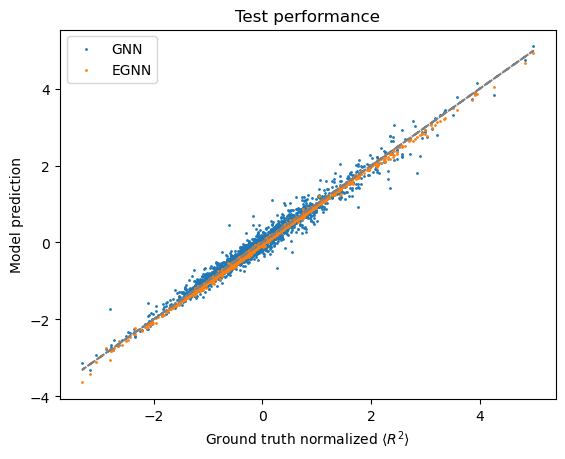

In [69]:
fig, ax = plt.subplots()
ax.plot(gcn_targets, gcn_targets, "--", color="grey")
ax.scatter(gcn_targets, gcn_preds, s=1, label="GNN")
ax.scatter(egnn_targets, egnn_preds, s=1, label="EGNN")
ax.set_ylabel("Model prediction")
ax.set_xlabel("Ground truth normalized $\langle R^2 \\rangle$")
ax.set_title("Test performance")
ax.legend()

These findings support our initial hypothesis that $\text{E}(3)$-invariant models lead to faster learning and improved generalization performance.

## Discussion

### Summary
You have now seen, theoretically and practically, why we need $(S)E(3)$ to work with point cloud representations of molecules and how to implement, train and evaluate them. The dataset used here is not directly relevant to CADD, but the practical importance of $(S)E(3)$ equi-/invariance definitely carries over to more relevant applications such as protein ligand docking. Recent work on molecular representation learning also suggests that 3D point clouds are favored for a broad range of property prediction tasks more relevant to CADD such as toxicity prediction.

### Caveats of our approach
At this point, we should also go over some final caveats with the EGNN presented here and our approach in general:

1. Our model assumes that every atom interacts with every other atom, i.e. the neighborhood of node $i$, $N(i) = \{j \neq i\}$ is complete. This approach has quadratic complexity meaning its more computationally expensive (go back to the model training and compare how long one epoch takes compared to the plain GNN) and thus might not be scalable to larger molecules. In this case we could restrict interactions by instead using 
   * $k$-nearest neighborhoods, i.e. $|N(i)| = k$ contains the $k$ nodes with the smallest euclidean distance to $i$,
   * or spherical neighborhoods with a fixed radius $\delta$ instead, i.e. $N(i) = \{j \mid ||X_i - X_j||^2 \leq \delta\}$
3. Our EGNN model is $E(3)$-invariant. Note that some molecular properties are *sensitive* to reflection, In such settings, $SE(3)$-invariance should be the preferred model property (see **Talktorial T033**).
4. Random data splits are considered bad practice for measuring the capability of a molecular machine learning model to generalize to unseen data (see [this paper](https://jcheminf.biomedcentral.com/articles/10.1186/s13321-019-0391-2) which analyzes and discusses this issue in-depth for QM9)


## Quiz

1. In addition to 3D coordinates, what is strictly required for inference of covalent bonds between atoms?
2. What is the difference between equivariance and invariance?
3. True or false? $SE(3)$ contains transformations which are not included in $E(3)$.
4. True or false? The atom embeddings $h$ computed by iterating the following message passing scheme for a fixed number of steps are $E(3)$-invariant
$$m_{ij}^{l} = \phi_{l}(h_i^l, h_j^l, X_i - X_j)$$
$$h_{i}^{l+1} = \psi_l(h_{i}^l, \sum_{j \neq i} m_{ij}^l)$$